Changes from v2

- implemented the possiblity to add nodes to the system
- add new visualization based data frame

**Importing Dependencies**

In [1]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
# Probably not needed --> test ray lib instead
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

from Environment.env_v4 import *
from Functions.visualization_functions import *

**Configuration of the Scenario**

In [2]:
# Configuration of the network
# Sample JSON configuration (replace this with your JSON data)
with open('./Config/network_config_v0.json') as file:
    network_config = file.read()

# TODO : Implement configuaration for cost and demand (actual and exptected)

**Building the environment**

In [3]:
EP_LENGTH = 30 # Length of the episode

env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

Node Attributes:
Node A: {'type': 'manufacturer', 'I': 30}
Node B: {'type': 'manufacturer', 'I': 28}
Node C: {'type': 'manufacturer', 'I': 32}
Node D: {'type': 'distributor'}
Node S: {'type': 'source'}


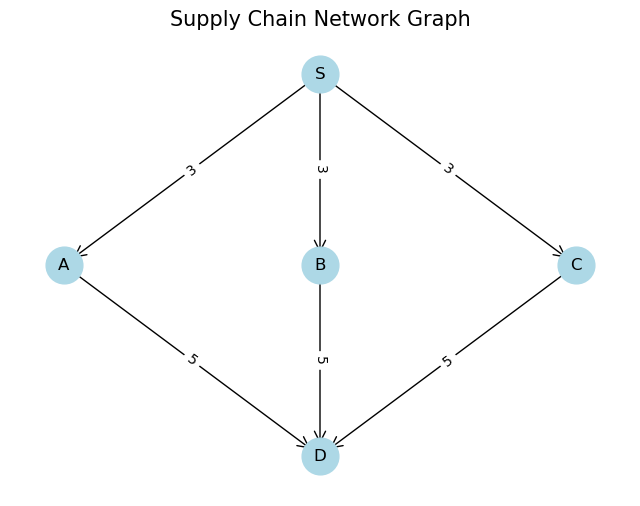

In [4]:
env.render_network()

In [5]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True)

**Testng the environment**

In [6]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info, _ = env.step(action)
        score += reward

        # print('Step t:{} Score:{} Stock:{} Order:{} Delivered:{} Exp Demand t+3:{} Act Demand:{}'.format((EP_LENGTH - env.episode_length), score, n_state[0], action, env.delivered, n_state[1], env.demand))

        env.render()

    # print(env.order_history)

Episode Length: 1
Stock Level: [27.  21.4 32. ]
Planned Demand: [3.8 8.  0. ]
Actual Demand: [3.  6.6 0. ]
Action: [12.  10.8 15.9]
Order: [0 0 0]
Reward: -269.0969777216495

Episode Length: 2
Stock Level: [19.4 16.2 23.4]
Planned Demand: [9.4 4.1 8.4]
Actual Demand: [7.6 5.2 8.6]
Action: [ 5.8 18.9  0.5]
Order: [0 0 0]
Reward: -503.21012343599403

Episode Length: 3
Stock Level: [19.4  3.9 13. ]
Planned Demand: [ 0.  13.3 10.6]
Actual Demand: [ 0.  12.3 10.3]
Action: [19.3 11.9  0.9]
Order: [0 0 0]
Reward: -721.6853563313285

Episode Length: 4
Stock Level: [20.4 14.7 28.9]
Planned Demand: [11.5  0.   0. ]
Actual Demand: [11.  0.  0.]
Action: [4.2 8.1 9.8]
Order: [12.  10.8 15.9]
Reward: -957.8058832450411

Episode Length: 5
Stock Level: [14.2 26.7 17.8]
Planned Demand: [ 9.5  8.6 12. ]
Actual Demand: [12.   6.9 11.7]
Action: [1.1 4.  2.9]
Order: [ 5.8 18.9  0.5]
Reward: -1174.4797699851501

Episode Length: 6
Stock Level: [33.5 19.9 10. ]
Planned Demand: [ 0.  15.7  7.2]
Actual Demand: 

**Train Model**


In [24]:
log_path = os.path.join('Training', 'Logs')
model_path = os.path.join('Training', 'Models', 'PPO')

In [25]:
env = SS_Mngmt_Env(network_config=network_config,
                   EP_LENGTH=EP_LENGTH,
                   render_mode="human")

env = DummyVecEnv([lambda: env])

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device


In [26]:
model.learn(total_timesteps=10000)

Logging to Training/Logs/PPO_54
-----------------------------
| time/              |      |
|    fps             | 5813 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 3239          |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.6937785e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 5.36e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.81e+09      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00023      |
|    std                  | 1             |
|    value

In [27]:
evaluate_policy(model, env, n_eval_episodes=1, render=True, return_episode_rewards=True)

Episode Length: 1
Stock Level: [17.4 15.9 32. ]
Planned Demand: [ 9.9 13.   0. ]
Actual Demand: [12.6 12.1  0. ]
Action: [9.9 9.9 9.9]
Order: [0 0 0]
Reward: -245.04688537024458

Episode Length: 2
Stock Level: [17.4  3.4 32. ]
Planned Demand: [0.  9.4 0. ]
Actual Demand: [ 0.  12.5  0. ]
Action: [9.9 9.9 9.9]
Order: [0 0 0]
Reward: -477.5869657568671

Episode Length: 3
Stock Level: [17.4  3.4 19.1]
Planned Demand: [ 0.  13.1 12.3]
Actual Demand: [ 0.  12.7 12.9]
Action: [9.9 9.9 9.9]
Order: [0 0 0]
Reward: -1697.2532933493671

Episode Length: 4
Stock Level: [18.2  0.6 29.1]
Planned Demand: [6.9 0.  0. ]
Actual Demand: [9.1 0.  0. ]
Action: [9.9 9.9 9.9]
Order: [9.9 9.9 9.9]
Reward: -1924.872208404174

Episode Length: 5
Stock Level: [ 7.7 10.5 24.9]
Planned Demand: [17.9  0.  12.6]
Actual Demand: [20.4  0.  14.1]
Action: [9.9 9.9 9.9]
Order: [9.9 9.9 9.9]
Reward: -2147.766829778724

Episode Length: 6
Stock Level: [ 4.8 20.4 26.6]
Planned Demand: [15.1  0.   9.9]
Actual Demand: [12.8  0.

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


([-173048.68855285645], [30])

In [28]:
df = pd.read_csv('./Data/2024-10-14_19_last_environment_data.csv')

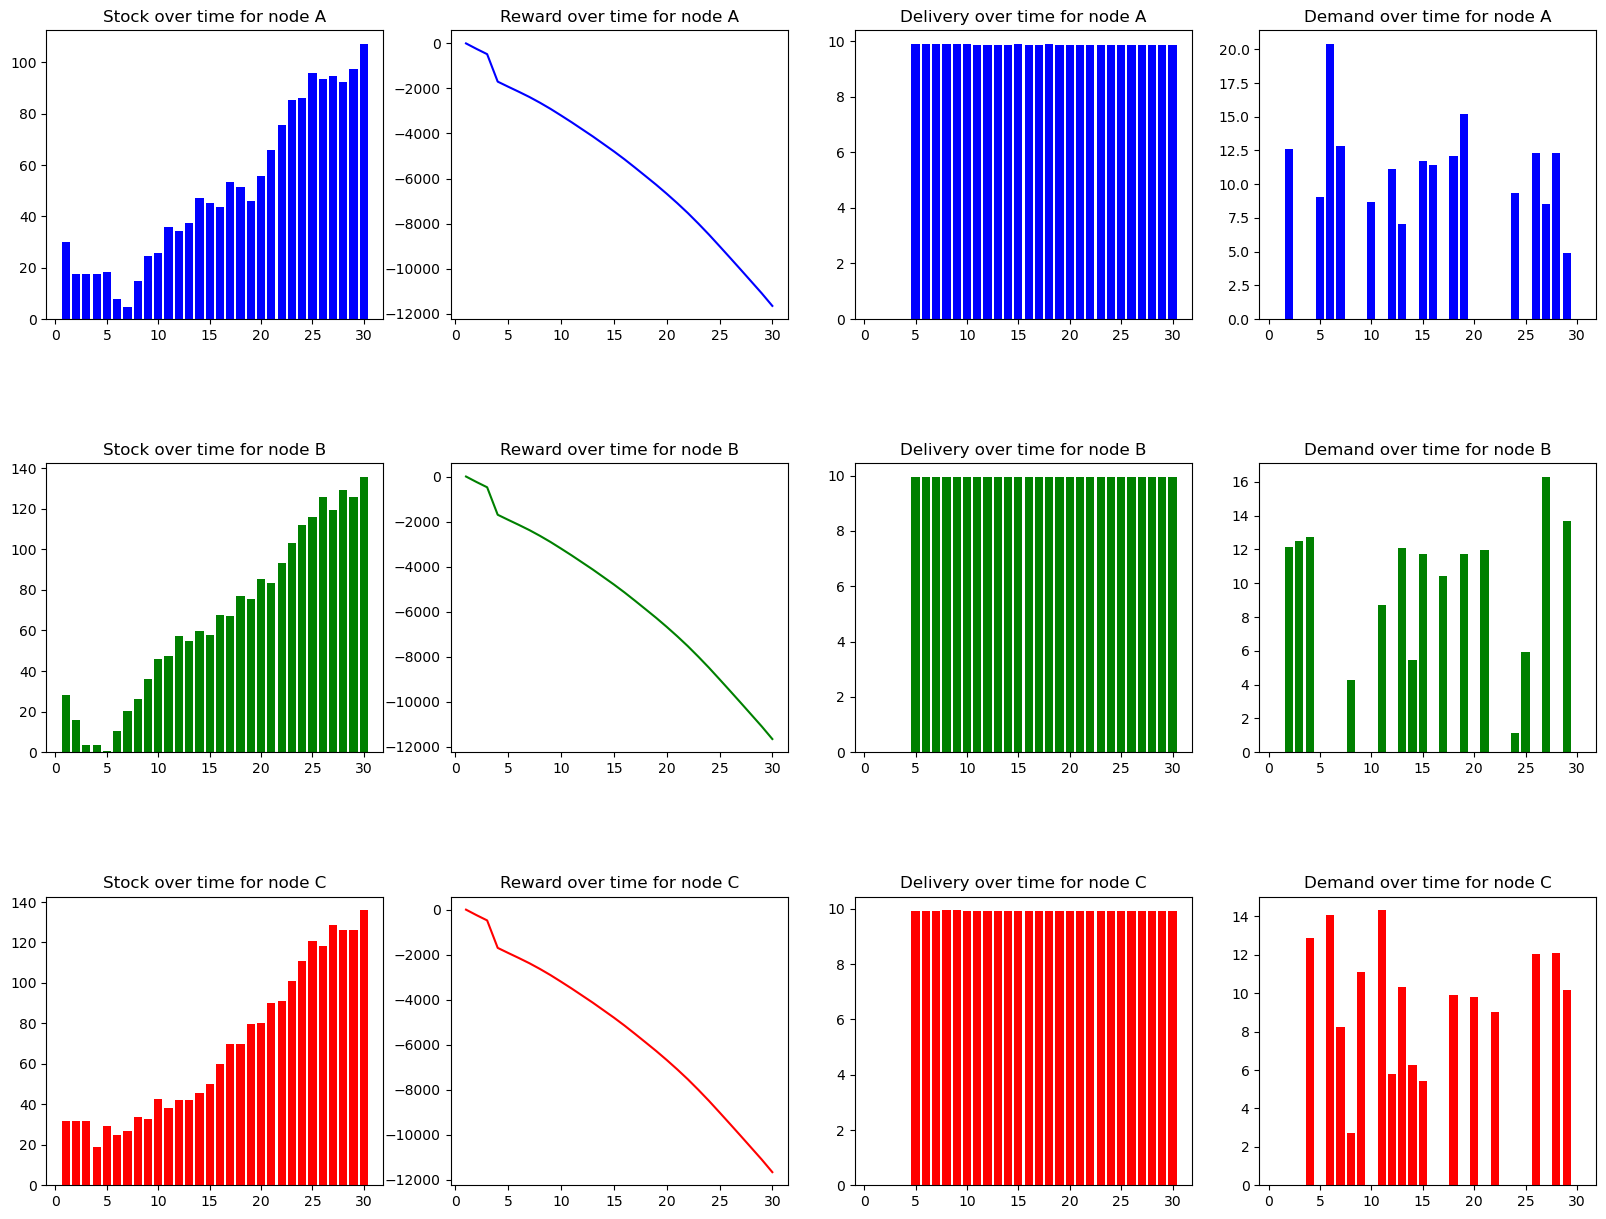

In [29]:
plot_data(df)